In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.mixed_precision import set_global_policy

In [5]:
set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


In [6]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [8]:
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')

X_train = X_train/255.0
X_valid = X_valid/255.0
X_test = X_test/255.0

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,           
    width_shift_range=0.2,       
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,       
    fill_mode='nearest'
)

datagen.fit(X_train)

In [10]:
from tensorflow.keras.regularizers import l2
model = Sequential()


model.add(Conv2D(filters=32, 
                    kernel_size=(3, 3), 
                    activation=None,  # Remove activation temporarily for Batch Normalization
                    padding='same',  # Added padding
                    input_shape=(32, 32, 3), 
                    kernel_regularizer=l2(1e-4)))  # Added L2 regularization
model.add(BatchNormalization())  # Added Batch Normalization
model.add(tf.keras.layers.Activation('relu'))  # Apply activation after Batch Normalization
model.add(MaxPooling2D(pool_size=(2, 2)))  # Static pooling layer
model.add(Dropout(0.3))  # Added Dropout after pooling



model.add(Conv2D(filters=192, 
                    kernel_size=(5, 5), 
                    activation=None,  # Remove activation temporarily for Batch Normalization
                    padding='same',  # Added padding
                    kernel_regularizer=l2(1e-4)))  # Added L2 regularization
model.add(BatchNormalization())  # Added Batch Normalization
model.add(tf.keras.layers.Activation('relu'))  # Apply activation after Batch Normalization
model.add(MaxPooling2D(pool_size=(2, 2)))  # Static pooling layer
model.add(Dropout(0.3))  # Added Dropout after pooling



model.add(Conv2D(filters=128, 
                    kernel_size=(3, 3), 
                    activation=None,  # Remove activation temporarily for Batch Normalization
                    padding='same',  # Added padding
                    kernel_regularizer=l2(1e-4)))  # Added L2 regularization
model.add(BatchNormalization())  # Added Batch Normalization
model.add(tf.keras.layers.Activation('relu'))  # Apply activation after Batch Normalization
model.add(Dropout(0.3))  # Added Dropout for deeper regularization

# Flatten the feature maps
model.add(Flatten())


model.add(Dense(units=320, activation=None, kernel_regularizer=l2(1e-4)))  # Added L2 regularization
model.add(BatchNormalization())  # Added Batch Normalization
model.add(tf.keras.layers.Activation('relu'))  # Apply activation after Batch Normalization

# Output layer for 10 classes
model.add(Dense(10, activation='softmax'))


# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 192)       1

In [12]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

In [14]:
model.fit(datagen.flow(X_train, y_train, batch_size=64), epochs=50, validation_data=(X_valid,y_valid),callbacks=[stop_early])

Epoch 1/50
704/704 [==============================] - 35s 47ms/step - loss: 1.3498 - accuracy: 0.5565 - val_loss: 1.4811 - val_accuracy: 0.5713
Epoch 2/50
704/704 [==============================] - 26s 37ms/step - loss: 1.2732 - accuracy: 0.5798 - val_loss: 1.6063 - val_accuracy: 0.5522
Epoch 3/50
704/704 [==============================] - 26s 37ms/step - loss: 1.2300 - accuracy: 0.5985 - val_loss: 1.6786 - val_accuracy: 0.5202
Epoch 4/50
704/704 [==============================] - 26s 37ms/step - loss: 1.2055 - accuracy: 0.6047 - val_loss: 1.2991 - val_accuracy: 0.6026
Epoch 5/50
704/704 [==============================] - 26s 37ms/step - loss: 1.1763 - accuracy: 0.6164 - val_loss: 1.3204 - val_accuracy: 0.6032
Epoch 6/50
704/704 [==============================] - 27s 39ms/step - loss: 1.1561 - accuracy: 0.6253 - val_loss: 1.1980 - val_accuracy: 0.6319
Epoch 7/50
704/704 [==============================] - 26s 37ms/step - loss: 1.1325 - accuracy: 0.6303 - val_loss: 1.1580 - val_accuracy:

In [15]:
model.save('./cifar10_augmented')

INFO:tensorflow:Assets written to: ./cifar10_augmented\assets


INFO:tensorflow:Assets written to: ./cifar10_augmented\assets


In [18]:
import numpy as np

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class labels
y_true = y_test.flatten()

313/313 [==============================] - 2s 5ms/step


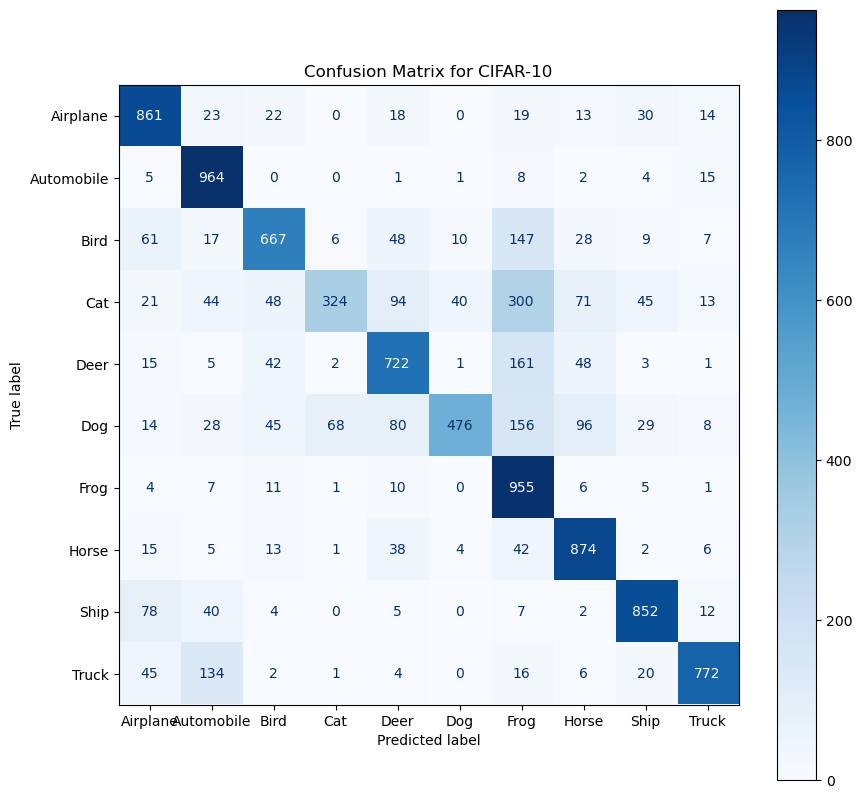

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred_classes)
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix for CIFAR-10")
plt.show()

In [20]:
report = classification_report(y_true, y_pred_classes, target_names=labels)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

    Airplane       0.77      0.86      0.81      1000
  Automobile       0.76      0.96      0.85      1000
        Bird       0.78      0.67      0.72      1000
         Cat       0.80      0.32      0.46      1000
        Deer       0.71      0.72      0.71      1000
         Dog       0.89      0.48      0.62      1000
        Frog       0.53      0.95      0.68      1000
       Horse       0.76      0.87      0.81      1000
        Ship       0.85      0.85      0.85      1000
       Truck       0.91      0.77      0.84      1000

    accuracy                           0.75     10000
   macro avg       0.78      0.75      0.74     10000
weighted avg       0.78      0.75      0.74     10000

